# Download Seismic Data

In this notebook, we will download continuous seismic data from a public data center with `obspy`.

In [1]:
from BPMF.config import cfg
import glob
import obspy as obs
import os

from datetime import datetime, timedelta
from obspy.clients.fdsn import mass_downloader

In [2]:
DATE = obs.UTCDateTime("2012-07-26")
DATA_BUFFER_SEC = 500.

## Defining and Initializing the Data Folder Architecture

In [3]:
ROOTDIRPATH_DATA = cfg.INPUT_PATH
dirpath_data = os.path.join(ROOTDIRPATH_DATA, str(DATE.year), DATE.strftime("%Y%m%d"))
dirpath_raw_waveforms = os.path.join(dirpath_data, "raw")
dirpath_resp_files = os.path.join(dirpath_data, "resp")

# Create the repository if needed
if not os.path.isdir(dirpath_raw_waveforms):
    os.makedirs(dirpath_raw_waveforms)
if not os.path.isdir(dirpath_resp_files):
    os.makedirs(dirpath_resp_files)

## Data Selection

`obspy`'s fdsn downloader takes a `Domain` and a `Restrictions` instances to identify the data to request from the data center.

In [4]:
# Geographical restrictions
domain = mass_downloader.RectangularDomain(
    minlatitude=40.60,
    maxlatitude=40.76,
    minlongitude=30.20,
    maxlongitude=30.44,
)

# Time and station restrictions
restrictions = mass_downloader.Restrictions(
    starttime=DATE - DATA_BUFFER_SEC,
    endtime=DATE + timedelta(days=1.) + DATA_BUFFER_SEC,
    network="YH",
    location="*",
    channel="BH*,HH*",
    station="SAUV,SPNC,DC08,DC07,DC06,DD06,DE07,DE08",
    reject_channels_with_gaps=False,
    minimum_length=0.0,
    minimum_interstation_distance_in_m=500.0,
    channel_priorities=["HH[ZNE]", "BH[ZNE]"],
)

# Downloader instance
downloader = mass_downloader.MassDownloader(providers=["IRIS"])

[2025-09-08 15:21:22,550] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for IRIS.


[2025-09-08 15:21:22,861] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): IRIS.


## Download the Data

In [5]:
# don't hesitate running this cell many times to make
# sure all the available data were downloaded
# some requests may fail due to busy data centers
downloader.download(
    domain,
    restrictions,
    mseed_storage=dirpath_raw_waveforms,
    stationxml_storage=dirpath_resp_files,
    threads_per_client=16,
)

[2025-09-08 15:21:22,866] - obspy.clients.fdsn.mass_downloader - INFO: Total acquired or preexisting stations: 0
[2025-09-08 15:21:22,867] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Requesting reliable availability.
[2025-09-08 15:21:23,322] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Successfully requested availability (0.45 seconds)
[2025-09-08 15:21:23,323] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Found 8 stations (24 channels).
[2025-09-08 15:21:23,324] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Will attempt to download data from 8 stations.
[2025-09-08 15:21:23,330] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Status for 24 time intervals/channels before downloading: EXISTS
[2025-09-08 15:21:23,892] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - No station information to download.
[2025-09-08 15:21:23,892] - obspy.clients.fdsn.mass_downloader - INFO: =============================

{'IRIS': <obspy.clients.fdsn.mass_downloader.download_helpers.ClientDownloadHelper at 0x7f4afd5bfd70>}

In [6]:
# check the files in DIRPATH_WAVEFORMS
glob.glob(os.path.join(dirpath_raw_waveforms, "*"))

['../BPMF_data/2012/20120726/raw/YH.DE08..BHE__20120725T235140Z__20120727T000820Z.mseed',
 '../BPMF_data/2012/20120726/raw/YH.DE07..BHN__20120725T235140Z__20120727T000820Z.mseed',
 '../BPMF_data/2012/20120726/raw/YH.DE08..BHZ__20120725T235140Z__20120727T000820Z.mseed',
 '../BPMF_data/2012/20120726/raw/YH.DD06..BHN__20120725T235140Z__20120727T000820Z.mseed',
 '../BPMF_data/2012/20120726/raw/YH.DC07..BHZ__20120725T235140Z__20120727T000820Z.mseed',
 '../BPMF_data/2012/20120726/raw/YH.SAUV..HHZ__20120725T235140Z__20120727T000820Z.mseed',
 '../BPMF_data/2012/20120726/raw/YH.DC07..BHE__20120725T235140Z__20120727T000820Z.mseed',
 '../BPMF_data/2012/20120726/raw/YH.SAUV..HHE__20120725T235140Z__20120727T000820Z.mseed',
 '../BPMF_data/2012/20120726/raw/YH.DC08..BHN__20120725T235140Z__20120727T000820Z.mseed',
 '../BPMF_data/2012/20120726/raw/YH.SPNC..BHZ__20120725T235140Z__20120727T000820Z.mseed',
 '../BPMF_data/2012/20120726/raw/YH.SPNC..BHE__20120725T235140Z__20120727T000820Z.mseed',
 '../BPMF_

## Cleanup the Downloaded Data

Even though `mass_downloader.Restrictions` handles channel priorities, some components might end up being downloaded at multiple channels because of failed data requests (see the output of the previous cell). To avoid data duplicate and in the interest of keeping the memory footprint low, we now remove these duplicated data.

In [7]:
from fnmatch import filter as fnfilter

In [8]:
# keep only HH channels when HH and BH channels were downloaded
data_list = glob.glob(os.path.join(dirpath_raw_waveforms, "*mseed"))
station_list = glob.glob(os.path.join(dirpath_resp_files, "*xml"))
for sta in station_list:
    sta_id, _ = os.path.splitext(os.path.basename(sta))
    print(sta_id)
    BH_channels = fnfilter(data_list, os.path.join(dirpath_raw_waveforms, f"{sta_id}.*.BH*__*.mseed"))
    for fname in BH_channels:
        cha_info = fname[len(dirpath_raw_waveforms)+len(sta_id):]
        if os.path.isfile(os.path.join(dirpath_raw_waveforms, sta_id + cha_info.replace(".BH", ".HH"))):
            # the HH channel exists as well
            # get rid of the BH channel
            os.remove(fname)
data_list = glob.glob(os.path.join(dirpath_raw_waveforms, "*mseed"))

YH.DE07
YH.SAUV
YH.DE08
YH.SPNC
YH.DD06
YH.DC06
YH.DC08
YH.DC07


In [9]:
data_list

['../BPMF_data/2012/20120726/raw/YH.DE08..BHE__20120725T235140Z__20120727T000820Z.mseed',
 '../BPMF_data/2012/20120726/raw/YH.DE07..BHN__20120725T235140Z__20120727T000820Z.mseed',
 '../BPMF_data/2012/20120726/raw/YH.DE08..BHZ__20120725T235140Z__20120727T000820Z.mseed',
 '../BPMF_data/2012/20120726/raw/YH.DD06..BHN__20120725T235140Z__20120727T000820Z.mseed',
 '../BPMF_data/2012/20120726/raw/YH.DC07..BHZ__20120725T235140Z__20120727T000820Z.mseed',
 '../BPMF_data/2012/20120726/raw/YH.SAUV..HHZ__20120725T235140Z__20120727T000820Z.mseed',
 '../BPMF_data/2012/20120726/raw/YH.DC07..BHE__20120725T235140Z__20120727T000820Z.mseed',
 '../BPMF_data/2012/20120726/raw/YH.SAUV..HHE__20120725T235140Z__20120727T000820Z.mseed',
 '../BPMF_data/2012/20120726/raw/YH.DC08..BHN__20120725T235140Z__20120727T000820Z.mseed',
 '../BPMF_data/2012/20120726/raw/YH.SPNC..BHZ__20120725T235140Z__20120727T000820Z.mseed',
 '../BPMF_data/2012/20120726/raw/YH.SPNC..BHE__20120725T235140Z__20120727T000820Z.mseed',
 '../BPMF_

## Plot the Raw Data



In [10]:
traces = obs.Stream()
for fname in data_list:
    traces += obs.read(fname)
traces

24 Trace(s) in Stream:

YH.DE08..BHE | 2012-07-25T23:51:40.000000Z - 2012-07-27T00:08:20.000000Z | 50.0 Hz, 4370001 samples
...
(22 other traces)
...
YH.DD06..BHZ | 2012-07-25T23:51:40.000000Z - 2012-07-27T00:08:20.000000Z | 50.0 Hz, 4370001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

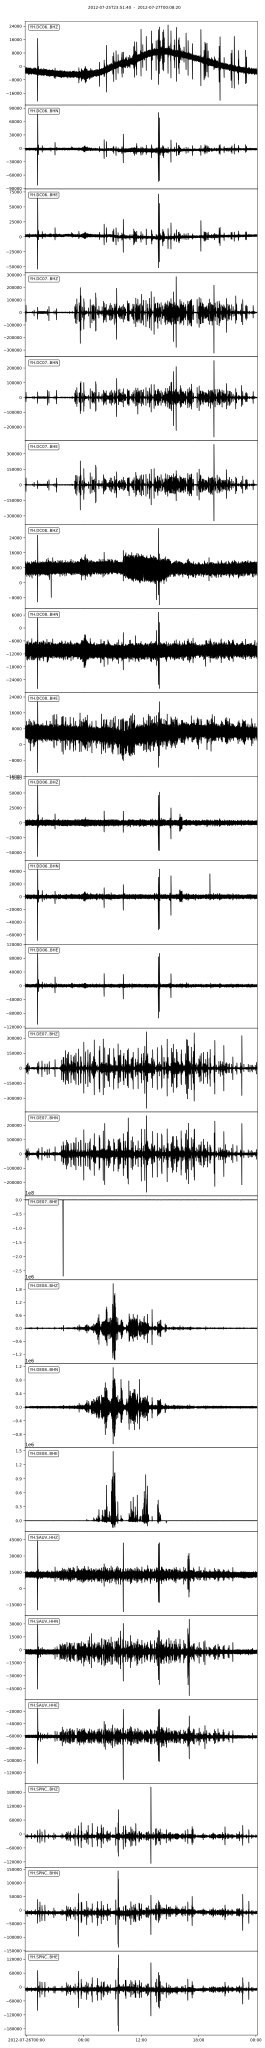

In [11]:
%config InlineBackend.figure_formats = ["svg"]

fig = traces.plot(equal_scale=False)